## Load Packages and Data

In [79]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV

from tqdm import tqdm


# this extension properly formats a cell after it is run
# !{sys.executable} -m pip install nb_black # UNCOMMENT TO INSTALL
%load_ext nb_black
%matplotlib inline

# Set the maximum number of rows to 200
pd.set_option("display.max_rows", 200)

# Set the maximum number of columns to 200
pd.set_option("display.max_columns", 200)

The nb_black extension is already loaded. To reload it, use:
  %reload_ext nb_black


<IPython.core.display.Javascript object>

In [2]:
# Load Data
train_set = pd.read_csv("../data/train_set.csv")
test_set = pd.read_csv("../data/test_set.csv")

<IPython.core.display.Javascript object>

In [3]:
train_set.columns

Index(['PID', 'GrLivArea', 'SalePrice', 'MSSubClass', 'MSZoning',
       'LotFrontage', 'LotArea', 'Street', 'Alley', 'LotShape', 'LandContour',
       'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1',
       'Condition2', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'ExterQual', 'ExterCond',
       'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
       'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF',
       '2ndFlrSF', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive',

<IPython.core.display.Javascript object>

## Function from Creating_test_train notbook with a few changes ##

In [4]:
## Group Streets by Sale Price ##

# creating a function to create groups based on mean sale price of streets in each
# neighborhood of the training df and adds a new column with the groups created
# It then uses the groups created using the training dataframe and creates a new column
# in the testing dataframe by mapping these groups.  This will result in missing values
# If there is a street neighborhood combination that was in the training dataset but 
# not the testing dataset


def group_neighbor_streets_by_saleprice(
    traindf=train_set, testdf=test_set, num_quantiles=10  # notice the difference in this line!!
):
    # Calculate the mean sale price for each street in the training df
    street_prices = traindf.groupby("Neighborhood_st")["SalePrice"].mean()
    
    # Group the streets into the specified number of quantiles based on sale price
    labels = [f"group_{i+1}" for i in range(num_quantiles)]
    groups = pd.qcut(street_prices, q=num_quantiles, labels=range(1, num_quantiles + 1))
    
    # Create a dictionary that maps each street name to its corresponding sale price group label
    street_group_dict = dict(zip(street_prices.index, groups))
    
    # Add a new column to the training dataframe with the street price groups
    traindf["StreetPriceGroup"] = traindf["Neighborhood_st"].map(street_group_dict)
    
    # Add a new column to the testing dataframe with the street price groups
    testdf["StreetPriceGroup"] = testdf["Neighborhood_st"].map(street_group_dict)
    return street_group_dict


<IPython.core.display.Javascript object>

In [5]:
# the num of quantiles can be changed and it is assigned to d which is the dictionary that
# will be used to fill in the missing values

d = group_neighbor_streets_by_saleprice(
    traindf=train_set,  # the difference here as well!!
    testdf=test_set,  # the difference here as well!!
    num_quantiles=10,
)

<IPython.core.display.Javascript object>

In [6]:
## Supporting Function to group_neighbor_streets_by_saleprice to FILL_NA's ##

# Dictionary stores missing values in the test df with another group in the same neighborhood


def fill_na(testdf=test_set, d={}):  # DIFFERENT HERE TOO
    # Extract the first part of the string in the "Neighborhood_st" column
    testdf["Neighborhood_prefix"] = testdf["Neighborhood_st"].map(
        lambda x: x.split("_")[0]
    )

    # Create a new dict that only contains the neighborhood
    new_dict = {k.split("_")[0]: v for k, v in d.items()}

    # Create a list of PIDs with missing StreetPriceGroup values
    na_pid_list = testdf[testdf["StreetPriceGroup"].isna()]["PID"].tolist()

    # Create a Boolean mask to filter the DataFrame
    mask = testdf["PID"].isin(na_pid_list)

    # Apply the dictionary mapping only to the filtered rows
    testdf.loc[mask, "StreetPriceGroup"] = testdf[mask]["Neighborhood_prefix"].map(
        new_dict
    )

    # Drop the column since there is no more use for it
    testdf.drop("Neighborhood_prefix", axis=1, inplace=True)

<IPython.core.display.Javascript object>

In [7]:
fill_na(test_set, d)

<IPython.core.display.Javascript object>

In [8]:
# Remove the column that was used to create groupings
train_set.drop("Neighborhood_st", axis=1, inplace=True)
test_set.drop("Neighborhood_st", axis=1, inplace=True)

<IPython.core.display.Javascript object>

In [9]:
# Looks like PID should be removed and SalePrice moved to the first column
train_set

,PID,GrLivArea,SalePrice,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,ScreenPorch,Fence,MoSold,YrSold,SaleType,SaleCondition,Age,RemodAge,TotalSF,Remodeled,TotalPorchSF,TotalBath,MSSubClass_cat,Street_type,StreetPriceGroup
0,534477270,1661,165500,80,RL,80.0,9600,Pave,No_Alley,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,SLvl,6,6,1955,1996,Hip,CompShg,AsbShng,AsbShng,None,0.0,2,2,CBlock,3,3,4,4,831.0,1,0.0,161.0,992.0,GasA,3,Y,SBrkr,1661,0,1.0,0.0,1,0,3,1,3,8,Typ,1,3,BuiltIn,1955.0,2,1.0,377.0,3,3,Y,0,28,0,178,3,10,2008,WD,Normal,53,12,2653.0,1,206,2.0,subclass80,AVE,5
1,903233140,854,132000,45,RM,51.0,6120,Pave,No_Alley,Reg,Lvl,AllPub,Corner,Gtl,BrkSide,Norm,Norm,1Fam,1.5Unf,7,8,1929,2001,Gable,CompShg,Wd Sdng,Wd Sdng,None,0.0,2,2,BrkTil,3,3,1,1,0.0,1,0.0,832.0,832.0,GasA,4,Y,FuseA,854,0,0.0,0.0,1,0,2,1,2,5,Typ,0,0,Detchd,1991.0,1,2.0,576.0,3,3,Y,48,112,0,0,4,7,2007,WD,Normal,78,6,1686.0,1,112,1.0,subclass45,AVE,3
2,923228370,1092,85500,160,RM,21.0,1890,Pave,No_Alley,Reg,Lvl,AllPub,Inside,Gtl,MeadowV,Norm,Norm,TwnhsE,2Story,4,6,1972,1972,Gable,CompShg,CemntBd,CmentBd,None,0.0,2,2,CBlock,3,3,1,3,294.0,1,0.0,252.0,546.0,GasA,2,Y,SBrkr,546,546,0.0,0.0,1,1,3,1,2,5,Typ,0,0,Attchd,1972.0,1,1.0,286.0,3,3,Y,0,0,64,0,0,6,2010,WD,Normal,38,38,1638.0,0,64,1.5,subclass160,DR,1
3,904101070,3086,200500,50,RL,138.0,18030,Pave,No_Alley,IR1,Bnk,AllPub,Inside,Gtl,ClearCr,Norm,Norm,1Fam,1.5Fin,5,6,1946,1994,Gable,CompShg,MetalSd,MetalSd,None,0.0,2,2,CBlock,3,3,1,3,152.0,4,469.0,977.0,1598.0,GasA,2,Y,SBrkr,1636,971,0.0,0.0,3,0,3,1,4,12,Maj1,1,4,No_Garage,-1.0,0,0.0,0.0,0,0,Y,122,0,0,0,3,3,2007,WD,Normal,61,13,4684.0,1,0,3.0,subclass50,RD,7
4,533236040,1441,174000,160,FV,24.0,2645,Pave,Pave,Reg,Lvl,AllPub,Inside,Gtl,Somerst,Norm,Norm,Twnhs,2Story,8,5,1999,2000,Gable,CompShg,MetalSd,MetalSd,BrkFace,456.0,3,2,PConc,4,3,1,1,0.0,1,0.0,776.0,776.0,GasA,4,Y,SBrkr,764,677,0.0,0.0,2,1,2,1,3,5,Typ,0,0,Detchd,1999.0,1,2.0,492.0,3,3,Y,206,0,0,0,0,11,2007,WD,Normal,8,7,2217.0,1,0,2.5,subclass160,DR,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2041,904100190,704,88750,20,RL,50.0,4280,Pave,No_Alley,IR1,Lvl,AllPub,Inside,Gtl,Sawyer,Norm,Norm,1Fam,1Story,4,9,1946,2001,Gable,CompShg,MetalSd,MetalSd,None,0.0,2,3,CBlock,2,3,1,1,0.0,1,0.0,560.0,560.0,GasA,4,Y,FuseA,704,0,0.0,1.0,1,0,2,1,1,4,Typ,0,0,CarPort,1946.0,1,1.0,220.0,3,3,Y,0,0,24,0,0,9,2009,WD,Normal,63,8,1264.0,1,24,1.5,subclass20,AVE,1
2042,534128190,2640,256900,60,RL,80.0,10400,Pave,No_Alley,Reg,Lvl,AllPub,Inside,Gtl,NWAmes,PosA,Norm,1Fam,2Story,6,7,1967,1997,Gable,CompShg,MetalSd,MetalSd,BrkFace,256.0,2,2,PConc,3,3,1,1,0.0,1,0.0,932.0,932.0,GasA,3,Y,SBrkr,1271,1369,0.0,0.0,2,1,5,1,3,8,Typ,1,3,Attchd,1967.0,2,2.0,515.0,3,3,Y,0,120,0,168,0,5,2009,WD,Normal,42,12,3572.0,1,288,2.5,subclass60,AVE,8
2043,528142110,1944,360000,20,RL,90.0,12378,Pave,No_Alley,IR1,Lvl,AllPub,Inside,Gtl,NridgHt,Norm,Norm,1Fam,1Story,9,5,2003,2004,Gable,CompShg,VinylSd,VinylSd,None,0.0,3,2,PConc,5,3,3,6,1274.0,1,0.0,622.0,1896.0,GasA,4,Y,SBrkr,1944,0,1.0,0.0,2,0,3,1,4,8,Typ,3,5,At

<IPython.core.display.Javascript object>

In [10]:
# Remove PID and move SalePrice to first column
# I need to do this in the future and save the csv's after so we dont have to do this each time

# TRAIN
train_set = train_set.iloc[
    :,
    train_set.columns.tolist().index("SalePrice") : (
        train_set.columns.tolist().index("SalePrice") + 1
    ),
].join(train_set.drop(columns=["SalePrice", "PID"]))

# TEST
test_set = test_set.iloc[
    :,
    test_set.columns.tolist().index("SalePrice") : (
        test_set.columns.tolist().index("SalePrice") + 1
    ),
].join(test_set.drop(columns=["SalePrice", "PID"]))

<IPython.core.display.Javascript object>

## One Hot Encoding for Categorical Values

In [11]:
# In order to do regression, I need to turn categorical values into numerical values
train_set.dtypes

SalePrice             int64
GrLivArea             int64
MSSubClass            int64
MSZoning             object
LotFrontage         float64
LotArea               int64
Street               object
Alley                object
LotShape             object
LandContour          object
Utilities            object
LotConfig            object
LandSlope            object
Neighborhood         object
Condition1           object
Condition2           object
BldgType             object
HouseStyle           object
OverallQual           int64
OverallCond           int64
YearBuilt             int64
YearRemodAdd          int64
RoofStyle            object
RoofMatl             object
Exterior1st          object
Exterior2nd          object
MasVnrType           object
MasVnrArea          float64
ExterQual             int64
ExterCond             int64
Foundation           object
BsmtQual              int64
BsmtCond              int64
BsmtExposure          int64
BsmtFinType1          int64
BsmtFinSF1          

<IPython.core.display.Javascript object>

In [12]:
## DUMMIFY categorical columns into numerical values 0 or 1 ##


# List categorical columns to be dummified for train/test
cat_cols = train_set.select_dtypes(include=['object']).columns.tolist()

# Dummify the categorical columns in both train/test set
train_dummies = pd.get_dummies(train_set, columns=cat_cols)
test_dummies = pd.get_dummies(test_set, columns=cat_cols)

# Ensure the same dummy columns are present in both train and test sets
train_dummies, test_dummies = train_dummies.align(test_dummies, join='left', axis=1)

# Fill any missing columns in the test set with zeros
test_dummies.fillna(0, inplace=True)


<IPython.core.display.Javascript object>

In [13]:
# Did it work? yes!
train_dummies

,SalePrice,GrLivArea,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,HeatingQC,1stFlrSF,2ndFlrSF,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Fireplaces,FireplaceQu,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,WoodDeckSF,OpenPorchSF,EnclosedPorch,ScreenPorch,Fence,MoSold,YrSold,Age,RemodAge,TotalSF,Remodeled,TotalPorchSF,TotalBath,StreetPriceGroup,MSZoning_C (all),MSZoning_FV,MSZoning_I (all),MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Grvl,Street_Pave,Alley_Grvl,Alley_No_Alley,Alley_Pave,LotShape_IR1,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_Bnk,LandContour_HLS,LandContour_Low,LandContour_Lvl,Utilities_AllPub,Utilities_NoSewr,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,LandSlope_Gtl,LandSlope_Mod,LandSlope_Sev,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_Greens,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,...,Exterior1st_WdShing,Exterior2nd_AsbShng,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Plywood,Exterior2nd_PreCast,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,MasVnrType_BrkCmn,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,Foundation_BrkTil,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,Heating_Floor,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,CentralAir_N,CentralAir_Y,Electrical_FuseA,Electrical_FuseF,Electrical_FuseP,Electrical_SBrkr,Functional_Maj1,Functional_Maj2,Functional_Min1,Functional_Min2,Functional_Mod,Functional_Sal,Functional_Typ,GarageType_2Types,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_No_Garage,PavedDrive_N,PavedDrive_P,PavedDrive_Y,SaleType_COD,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_VWD,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,MSSubClass_cat_subclass120,MSSubClass_cat_subclass150,MSSubClass_cat_subclass160,MSSubClass_cat_subclass180,MSSubClass_cat_subclass190,MSSubClass_cat_subclass20,MSSubClass_cat_subclass30,MSSubClass_cat_subclass40,MSSubClass_cat_subclass45,MSSubClass_cat_subclass50,MSSubClass_cat_subclass60,MSSubClass_cat_subclass70,MSSubClass_cat_subclass75,MSSubClass_cat_subclass80,MSSubClass_cat_subclass85,MSSubClass_cat_subclass90,Street_type_AVE,Street_type_BLVD,Street_type_CIR,Street_type_CT,Street_type_DR,Street_type_EAST,Street_type_LN,Street_type_PKWY,Street_type_PL,Street_type_RD,Street_type_ST,Street_type_WAY
0,165500,1661,80,80.0,9600,6,6,1955,1996,0.0,2,2,3,3,4,4,831.0,1,0.0,161.0,992.0,3,1661,0,1.0,0.0,1,0,3,1,3,8,1,3,1955.0,2,1.0,377.0,3,3,0,28,0,178,3,10,2008,53,12,2653.0,1,206,2.0,5,0,0,0,0,1,0,0,1,0,1,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,132000,854,45,51.0,6120,7,8,1929,2001,0.0,2,2,3,3,1,1,0.0,1,0.0,832.0,832.0,4,854,0,0.0,0.0,1,0,2,1,2,5,0,0,1991.0,1,2.0,576.0,3,3,48,112,0,0,4,7,2007,78,6,1686.0,1,112,1.0,3,0,0,0,0,0,1,0,1,0,1,0,0,0,0,1,0,0,0,1,1,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,1

<IPython.core.display.Javascript object>

In [14]:
# Lot's of Columns now that we one-hot encoded!
print(train_dummies.shape)
print(test_dummies.shape)

(2046, 266)
(512, 266)


<IPython.core.display.Javascript object>

In [15]:
# Triple Check that there are no object values
train_strings = train_dummies.select_dtypes(include=["object"]).columns
test_strings = test_dummies.select_dtypes(include=["object"]).columns
print(train_strings)
print(test_strings)

Index([], dtype='object')
Index([], dtype='object')


<IPython.core.display.Javascript object>

## Gradient Boosting Regression Model

In [38]:
gbm = GradientBoostingRegressor()
kf = KFold(n_splits=5, shuffle=True, random_state=42)
X = train_dummies.loc[:, train_dummies.columns != "SalePrice"]
y = train_dummies.loc[:, "SalePrice"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)


<IPython.core.display.Javascript object>

In [39]:
# FIT
gbm.set_params(verbose=1)
gbm.fit(X, y)

      Iter       Train Loss   Remaining Time 
         1  4744017355.2889            1.63s
         2  4032987420.4925            1.61s
         3  3438648176.5347            1.55s
         4  2953704860.7124            1.46s
         5  2549924221.7292            1.37s
         6  2212468829.6443            1.29s
         7  1924725290.5892            1.23s
         8  1690737982.3684            1.18s
         9  1490109130.3724            1.13s
        10  1320825702.5261            1.10s
        20   546580643.8400            0.89s
        30   345005050.2996            0.76s
        40   267406972.8900            0.64s
        50   226476953.1206            0.53s
        60   202675767.6270            0.42s
        70   185652418.4615            0.31s
        80   173136504.0948            0.21s
        90   161702055.0895            0.10s
       100   151638531.8758            0.00s


GradientBoostingRegressor(verbose=1)

<IPython.core.display.Javascript object>

In [18]:
# k-fold cross-validation

# Create the Gradient Boosted Regression model and evaluate it using k-fold cross-validation
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score

mse_scores = []
r2_scores = []

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    model = GradientBoostingRegressor(
        n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42
    )
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    mse_scores.append(mse)
    r2_scores.append(r2)

print("MSE scores:", mse_scores)
print("R-squared scores:", r2_scores)

MSE scores: [322746634.2791484, 465856217.6223381, 369490124.33649755, 949124370.7377828, 325101453.40383786]
R-squared scores: [0.9352264122721555, 0.921725186226128, 0.9312188870117949, 0.8501043521734962, 0.9400063021503235]


<IPython.core.display.Javascript object>

The output shows the MSE and R-squared scores for each fold of the cross-validation. 
The MSE scores range from 322,746,634 to 949,124,370 while the R-squared scores range from 0.8501 to 0.9400. 

These scores indicate how well the model is performing on the testing data, with higher R-squared scores and lower MSE scores indicating better performance. 

The fact that the R-squared scores are relatively high and the MSE scores are relatively low suggests that the model is performing well on the data.

## Tuning

In [77]:
def tune_gbm(learning_rate, max_depth):
    gbm = GradientBoostingRegressor(
        learning_rate=learning_rate, n_estimators=10000, max_depth=max_depth
    )
    gbm.fit(X_train, y_train)

    return gbm


def demo_gbm_tuning(model, start=0, end=10000, training_curve=True):
    """
    This function takes a GBM regression model model as input and generates a 
    performance visualization of the model using the test dataset (X_test and y_test). 
    The function calculates the mean squared error (MSE) on both the training and test 
    datasets using a generator that iteratively predicts the targets for different numbers of estimators. 
    The start and end arguments control the range of the x-axis (i.e., the number of estimators), 
    and the training_curve argument controls whether to show the training curve or not. 
    The function also prints the best test score and the corresponding number of estimators.
    """
    gen_train = model.staged_predict(X_train)
    gen_test = model.staged_predict(X_test)

    trainMSE = []
    testMSE = []
    steps = range(1, 10001)
    for n in tqdm(steps):
        y_pred_train = next(gen_train)
        y_pred_test = next(gen_test)
        trainMSE.append(mean_squared_error(y_pred_train, y_train))
        testMSE.append(mean_squared_error(y_pred_test, y_test))

    print(
        "The best test score is {:.2f} at the step {}".format(
            min(testMSE), np.argmin(testMSE) + 1
        )
    )
    print("-" * 50)
    plt.plot(range(start, end), testMSE[start:end], label="test")
    if training_curve:
        plt.plot(range(start, end), trainMSE[start:end], label="train")
    plt.legend()
    plt.show()


<IPython.core.display.Javascript object>

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:01<00:00, 5070.99it/s]


The best test score is 546031931.48 at the step 7957
--------------------------------------------------


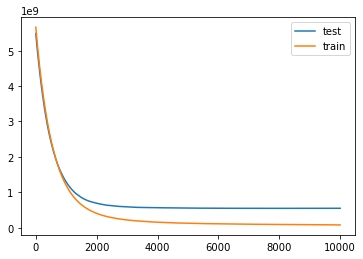

<IPython.core.display.Javascript object>

In [78]:
learning_rate = 0.001
max_depth = 4

model1 = tune_gbm(learning_rate, max_depth)

start = 0
end = 10000  # change start and end to zoom in

demo_gbm_tuning(model1, start, end)

The best test score is 302296534.17 at the step 813
--------------------------------------------------


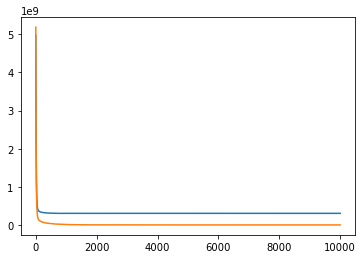

<IPython.core.display.Javascript object>

In [35]:
learning_rate = 0.05
max_depth = 4

model2 = tune_gbm(learning_rate, max_depth)

start = 0
end = 10000

demo_gbm_tuning(model2, start, end)

In [62]:
top_n = 20

sorted_importance = sorted(
    zip(X_train.columns, gbm.feature_importances_), key=lambda t: t[1], reverse=True,
)[:top_n]

sorted_importance

[('StreetPriceGroup', 0.5769564197811613),
 ('TotalSF', 0.17039454431939938),
 ('OverallQual', 0.13214268129921336),
 ('GrLivArea', 0.017558003371738247),
 ('2ndFlrSF', 0.009279232881821307),
 ('GarageCars', 0.008712722581689467),
 ('TotalBath', 0.008574201604716381),
 ('RemodAge', 0.007763921887858938),
 ('BsmtFinSF1', 0.007156417539837066),
 ('OverallCond', 0.006488391418938751),
 ('LotArea', 0.005744670468046936),
 ('GarageArea', 0.005685499888442132),
 ('KitchenQual', 0.005222793882662465),
 ('FireplaceQu', 0.0036806932598038664),
 ('BsmtQual', 0.0034255075004167098),
 ('YearRemodAdd', 0.0028959428511779925),
 ('Fireplaces', 0.0023381319471693046),
 ('BsmtFinType1', 0.002175965398737384),
 ('BsmtUnfSF', 0.0017094318286801165),
 ('Street_type_PKWY', 0.0016004674671428242)]

<IPython.core.display.Javascript object>

Text(0.5, 1.0, 'Feature Importance Plot')

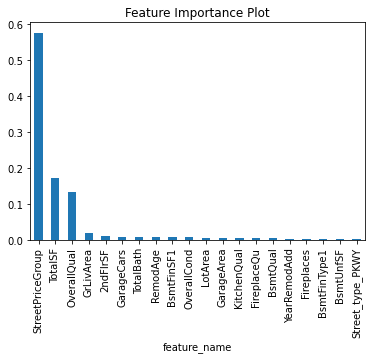

<IPython.core.display.Javascript object>

In [64]:
a, b = zip(*sorted_importance)  # this splits the list of tuples into two lists
pd.DataFrame({"feature_name": a, "importance_score": b}).plot.bar(
    x="feature_name", y="importance_score", legend=None
)
plt.title("Feature Importance Plot")

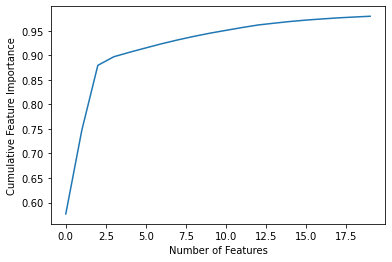

<IPython.core.display.Javascript object>

In [63]:
## Cumulative Feature Importance ##


cumulative_importance = np.cumsum([x[1] for x in sorted_importance])

plt.plot(cumulative_importance)
plt.xlabel("Number of Features")
plt.ylabel("Cumulative Feature Importance")
plt.show()

In [67]:
## WARNING ## 
## This takes 20+min to run ##

# Grid Search for best parameters

# Define the parameter grid to search
param_grid = {
    'learning_rate': [0.1, 0.05, 0.01],
    'n_estimators': [5000, 10000, 20000]
}

# Create a GBM model
gbm = GradientBoostingRegressor(max_depth=4)

# Perform grid search with cross-validation
grid_search = GridSearchCV(gbm, param_grid=param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Print the best parameters and best score
print("Best parameters: ", grid_search.best_params_)
print("Best score: ", -grid_search.best_score_)


Best parameters:  {'learning_rate': 0.01, 'n_estimators': 20000}
Best score:  -0.9284358533220967


<IPython.core.display.Javascript object>

## Colinearity

<AxesSubplot:>

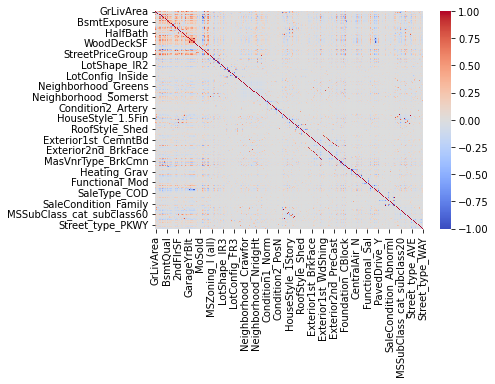

<IPython.core.display.Javascript object>

In [80]:
# Too many features for a heatmap
corr = X.corr()
sns.heatmap(corr, cmap="coolwarm", center=0)

In [83]:
corr

,GrLivArea,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,HeatingQC,1stFlrSF,2ndFlrSF,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Fireplaces,FireplaceQu,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,WoodDeckSF,OpenPorchSF,EnclosedPorch,ScreenPorch,Fence,MoSold,YrSold,Age,RemodAge,TotalSF,Remodeled,TotalPorchSF,TotalBath,StreetPriceGroup,MSZoning_C (all),MSZoning_FV,MSZoning_I (all),MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Grvl,Street_Pave,Alley_Grvl,Alley_No_Alley,Alley_Pave,LotShape_IR1,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_Bnk,LandContour_HLS,LandContour_Low,LandContour_Lvl,Utilities_AllPub,Utilities_NoSewr,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,LandSlope_Gtl,LandSlope_Mod,LandSlope_Sev,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_Greens,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,...,Exterior1st_WdShing,Exterior2nd_AsbShng,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Plywood,Exterior2nd_PreCast,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,MasVnrType_BrkCmn,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,Foundation_BrkTil,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,Heating_Floor,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,CentralAir_N,CentralAir_Y,Electrical_FuseA,Electrical_FuseF,Electrical_FuseP,Electrical_SBrkr,Functional_Maj1,Functional_Maj2,Functional_Min1,Functional_Min2,Functional_Mod,Functional_Sal,Functional_Typ,GarageType_2Types,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_No_Garage,PavedDrive_N,PavedDrive_P,PavedDrive_Y,SaleType_COD,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_VWD,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,MSSubClass_cat_subclass120,MSSubClass_cat_subclass150,MSSubClass_cat_subclass160,MSSubClass_cat_subclass180,MSSubClass_cat_subclass190,MSSubClass_cat_subclass20,MSSubClass_cat_subclass30,MSSubClass_cat_subclass40,MSSubClass_cat_subclass45,MSSubClass_cat_subclass50,MSSubClass_cat_subclass60,MSSubClass_cat_subclass70,MSSubClass_cat_subclass75,MSSubClass_cat_subclass80,MSSubClass_cat_subclass85,MSSubClass_cat_subclass90,Street_type_AVE,Street_type_BLVD,Street_type_CIR,Street_type_CT,Street_type_DR,Street_type_EAST,Street_type_LN,Street_type_PKWY,Street_type_PL,Street_type_RD,Street_type_ST,Street_type_WAY
GrLivArea,1.000000,0.071000,0.148455,0.297398,0.562274,-0.089536,0.216129,0.307543,0.386858,0.398518,-0.004296,0.339612,0.082296,0.068938,0.076043,0.174377,-0.032414,-0.018427,0.248978,0.427454,0.272448,0.546506,0.668027,0.043019,-0.034642,0.641710,0.445704,0.543408,0.129502,0.427581,0.809024,0.461755,0.482611,0.152386,0.339744,0.493044,0.480885,0.173175,0.150700,0.258802,0.312722,0.003162,0.107203,-0.111937,0.046867,-0.007904,-0.216466,-0.308759,0.872846,0.073625,0.259334,0.602007,0.600580,-0.034115,0.041858,0.015591,-0.026747,0.123701,-0.151853,-0.054592,0.054592,-0.029468,0.016105,0.011784,0.165559,0.076453,0.052382,-0.194517,0.042769,0.051572,0.001023,-0.061874,0.000618,-0.000618,0.027126,0.076502,-0.039591,0.000098,-0.050194,-0.028750,0.026629,0.010713,-0.011632,-0.045694,-0.074802,

<IPython.core.display.Javascript object>

In [ ]:
# eliminating columns 